<h1 align=center><font size = 5>Bitcoin OTC trust weighted signed network
</font></h1>

<h0 align=left><font size = 3>#bitcoin-otc is an over-the-counter marketplace for trading with bitcoin. The marketplace is located in #bitcoin-otc channel on the freenode IRC network. </font></h0>

https://www.bitcoin-otc.com/

<h0 align=left><font size = 3>To complement the OTC marketplace, they offer a web of trust service. Due to the p2p nature of OTC transactions, people are exposed to counterparty risk. To mitigate this risk, they need to have access to their counterparty's reputation and trade history. This is precisely the kind of information that the OTC web of trust provides. </font></h0>

## Data Set information 

<h0 align=left><font size = 3>This is who-trusts-whom network of people who trade using Bitcoin on a platform called Bitcoin OTC. Since Bitcoin users are anonymous, there is a need to maintain a record of users' reputation to prevent transactions with fraudulent and risky users. Members of Bitcoin OTC rate other members in a scale of -10 (total distrust) to +10 (total trust) in steps of 1. This is the first explicit weighted signed directed network available for research. </font></h0>

## Data format 

<h0 align=left><font size = 3>Each line has one rating, sorted by time, with the following format:

SOURCE, TARGET, RATING, TIME</font></h0>


## Necessary libraries 

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Drawing functions 

In [125]:
def draw_graph (G_sample):
    # draw the network G1
    fig= plt.figure(figsize=(20,15))
    nx.draw_spring(G_sample,node_color = 'g',with_labels=False,node_size=150,edge_color='Gray',alpha=0.7)
    return 

## Data preparations

In [126]:
data = pd.read_csv('data.csv')

In [127]:
data.head()

,Source,Target,Score,Time
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09


<h0 align=left><font size = 3>For instance I won't use the Time information as I will consider all scoring was on the same time for eveyone </font></h0>

In [128]:
data.columns

Index(['Source', 'Target', 'Score', 'Time'], dtype='object')

In [129]:
data.drop('Time', axis = 1,inplace = True)

In [130]:
print("The data size is : {} ".format(data.shape))

The data size is : (35592, 3) 


## Graph construction 

In [131]:
import networkx as nx

In [132]:
data_array=np.array(data)

In [133]:
G=nx.DiGraph()

In [134]:
data_array.shape[0]

35592

In [135]:
for i in range (data_array.shape[0]): 
    G.add_edge(data_array[i][0],data_array[i][1],score=data_array[i][2])

In [136]:
G.is_directed()

True

In [137]:
G.number_of_nodes()

5881

In [138]:
G.number_of_edges()

35592

## ScoingRank Algorithm 

In [139]:
def top_percent_page_rank(G , per = 0.02):
    page_rank = nx.pagerank(G, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight=None, dangling=None)

    lis=[]
    dic = dict(page_rank)

    #Top per of the data 
    n= int(per * G.number_of_nodes())

    for i in range (0,n) :
        maximum = 0 
        node = 0
        for elt in dic : 
            if dic[elt]> maximum  : 
                maximum = dic[elt]
                node = elt
            
        del dic[node]
        lis.append(node)
    lis_degree=lis
    #print(lis_degree)
    return lis_degree

In [140]:
def scoringRank (G,alpha=0.85,betta=3,gamma=0.8,num_iter=5,sigma=0) : 
    # alpha , the percentage taken from the received score from non popular nodes
    # betta , threshold that defines the minimum of in_degree to calculate the trust 
    # gamma, the percentage of nodes that are considered as specially popular 
    # num_iter, number of iterations to claculate the reusrive part of the the second step of the algo
    
    
    # initialisation the trust score to 0 
    for node in G.nodes():
        G.nodes[node]['trustworthiness']=0

    # making the trust score the sum of all the scores 
    for edge in G.edges(data=True) : 
        G.nodes[edge[1]]['trustworthiness']=G.nodes[edge[1]]['trustworthiness']+edge[2]['score']

    # considering the mean not the sum 
    for node in G.nodes():
        if (G.in_degree(node) >= betta):
            G.nodes[node]['trustworthiness']= G.nodes[node]['trustworthiness'] / (G.in_degree(node))
        else :
            G.nodes[node]['trustworthiness']= 0

    
    
    ###  Step 2 : Considering the initial score of the person who scored
    i=1
    while i<=num_iter :
        # initialisation the trust_2 score to 0 
        dic = {}
        for node in G.nodes():
            dic[node]=0
        # calculating trust_2 (considering trust_1 and the received scores )
        for edge in G.edges(data=True) : 
            if G.nodes[edge[0]]['trustworthiness'] > 0 : 
                if G.in_degree(edge[1]) >= betta :  
                    dic[edge[1]]=dic[edge[1]]+(edge[2]['score']/(G.in_degree(edge[1])))
        # trust receives trust_2
        for node in G.nodes() : 
            G.nodes[node]['trustworthiness']=dic[node]
        i=i+1 

    
    
    ### Step 3 : Giving greater importance to the nodes who are most popular 
    # scaled
    if sigma == 0 :
        list_popular_nodes= top_percent_page_rank(G , per = gamma) 
    elif sigma ==1 : 
        list_popular_nodes= top_percent_hub (G , per = gamma)

    dic = {}
    for node in G.nodes():
        dic[node]=0

    # calculating trust_2 (considering trust_1 and the received scores )
    for edge in G.edges(data=True) : 
        if G.nodes[edge[0]]['trustworthiness'] > 0 : 
            if G.in_degree(edge[1]) >= betta :  
                if edge[0] in list_popular_nodes : 
                    dic[edge[1]]=dic[edge[1]]+(edge[2]['score']*(2-alpha)/(G.in_degree(edge[1])))
                else : 
                    dic[edge[1]]=dic[edge[1]]+((edge[2]['score']*alpha)/(G.in_degree(edge[1])))

    # trust receives dic values 
    for node in G.nodes() : 
        G.nodes[node]['trustworthiness']=dic[node]
        
    return dict(G.nodes(data=True))

In [141]:
dict(G.nodes(data=True));

<h0 align=left><font size = 3> 
    * alpha    (0.8)  : the percentage taken from the received score from non popular nodes
    * betta    (3)    : threshold that defines the minimum of in_degree to calculate the trust 
    * gamma    (0.3)  : the percentage of nodes that are considered as specially popular 
    * num_iter (3)    : number of iterations to claculate the reusrive part of the the second step of the algo . 
   </font></h0>

In [142]:
scoringRank (G,alpha=0.8,betta=3,gamma=0.3,num_iter=3)

{6: {'trustworthiness': 1.609090909090909},
 2: {'trustworthiness': 3.4439024390243915},
 5: {'trustworthiness': 2.8},
 1: {'trustworthiness': 3.768141592920355},
 15: {'trustworthiness': 1.784615384615384},
 4: {'trustworthiness': 3.266666666666666},
 3: {'trustworthiness': -0.4952380952380956},
 13: {'trustworthiness': 1.7717277486911016},
 16: {'trustworthiness': 0},
 10: {'trustworthiness': 7.2},
 7: {'trustworthiness': 2.753703703703698},
 21: {'trustworthiness': 2.492307692307692},
 20: {'trustworthiness': 1.5599999999999996},
 8: {'trustworthiness': 6.8},
 17: {'trustworthiness': 2.8631578947368426},
 23: {'trustworthiness': 2.6307692307692303},
 25: {'trustworthiness': 2.7185840707964615},
 26: {'trustworthiness': 1.2363636363636363},
 28: {'trustworthiness': 1.890909090909091},
 29: {'trustworthiness': 1.8742857142857146},
 31: {'trustworthiness': 0},
 32: {'trustworthiness': 1.2},
 34: {'trustworthiness': 1.2},
 35: {'trustworthiness': 1.2575700934579495},
 36: {'trustworthin

## Robustess of the algorithm 

<h0 align=left><font size = 3> 
    We will see the variation of the results if we eliminate some edges.
   </font></h0>

In [143]:
G.number_of_nodes()

5881

In [144]:
G.number_of_edges()

35592

In [145]:
import random 

In [146]:
# N percentage of nodes we want to preserve in the subgraph 
def sub_graph(G,N): 
    l=list(G.edges(data=True))
    random.shuffle(l)
    n= int((1-N)* G.number_of_edges()) # n is the number of edges we will eliminate 
    for i in range(0,n): 
        l.pop(0)
        
    G_test=nx.DiGraph()
    for i in range (len(l)): 
        G_test.add_edge(l[i][0],l[i][1],score=l[i][2]['score'])
        
    return G_test

In [147]:
G1=sub_graph(G,0.1) # 10% of the complete graph 
G2=sub_graph(G,0.2) 
G3=sub_graph(G,0.3)
G4=sub_graph(G,0.4)
G5=sub_graph(G,0.5)
G6=sub_graph(G,0.6)
G7=sub_graph(G,0.7)
G8=sub_graph(G,0.8)
G9=sub_graph(G,0.9) # 90% of the complete graph 

In [148]:
G9.number_of_nodes()

5802

In [149]:
# trust values obtained by the scoringRank algorithm apllied on the whole graph 
dictionnaire_complet = scoringRank (G,alpha=0.8,betta=3,gamma=0.3,num_iter=3)

In [150]:
dictionnare_1 = scoringRank (G1,alpha=0.8,betta=3,gamma=0.3,num_iter=3)
dictionnare_2 = scoringRank (G2,alpha=0.8,betta=3,gamma=0.3,num_iter=3)
dictionnare_3 = scoringRank (G3,alpha=0.8,betta=3,gamma=0.3,num_iter=3)
dictionnare_4 = scoringRank (G4,alpha=0.8,betta=3,gamma=0.3,num_iter=3)
dictionnare_5 = scoringRank (G5,alpha=0.8,betta=3,gamma=0.3,num_iter=3)
dictionnare_6 = scoringRank (G6,alpha=0.8,betta=3,gamma=0.3,num_iter=3)
dictionnare_7 = scoringRank (G7,alpha=0.8,betta=3,gamma=0.3,num_iter=3)
dictionnare_8 = scoringRank (G8,alpha=0.8,betta=3,gamma=0.3,num_iter=3)
dictionnare_9 = scoringRank (G9,alpha=0.8,betta=3,gamma=0.3,num_iter=3)

In [151]:
dic_list=[dictionnare_1,dictionnare_2,dictionnare_3,dictionnare_4,dictionnare_5,dictionnare_6,dictionnare_7,dictionnare_8,dictionnare_9]

<h0 align=left><font size = 2>  
    We suppose the results of the complete are perfect so the error is null .
    We calculate epsilon as the sum of the differences between the perfect result and the subgraph and then we divise by the sum of all the edges. </font></h0>

In [152]:
error = [0.]*10

In [153]:
error 

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [157]:
for i in range (0,9) : 
    eps = 0 
    dictionnaire = dic_list[i]
    for key in dictionnaire.keys() : 
        eps=eps+abs(dictionnaire[key]['trustworthiness']-dictionnaire_complet[key]['trustworthiness'])
    error[i]=eps/ len(dictionnaire.keys())

In [158]:
error

[1.3246576355573088,
 1.0823601051277403,
 0.9046462179081382,
 0.7396590531011981,
 0.6328119312337688,
 0.49299797915252436,
 0.3798313552067463,
 0.2670120948535401,
 0.1271316688833719,
 0.0]

In [159]:
x=[str(i)+'%'  for i in range(10,110,10)]

In [160]:
x

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']

In [161]:
y=error

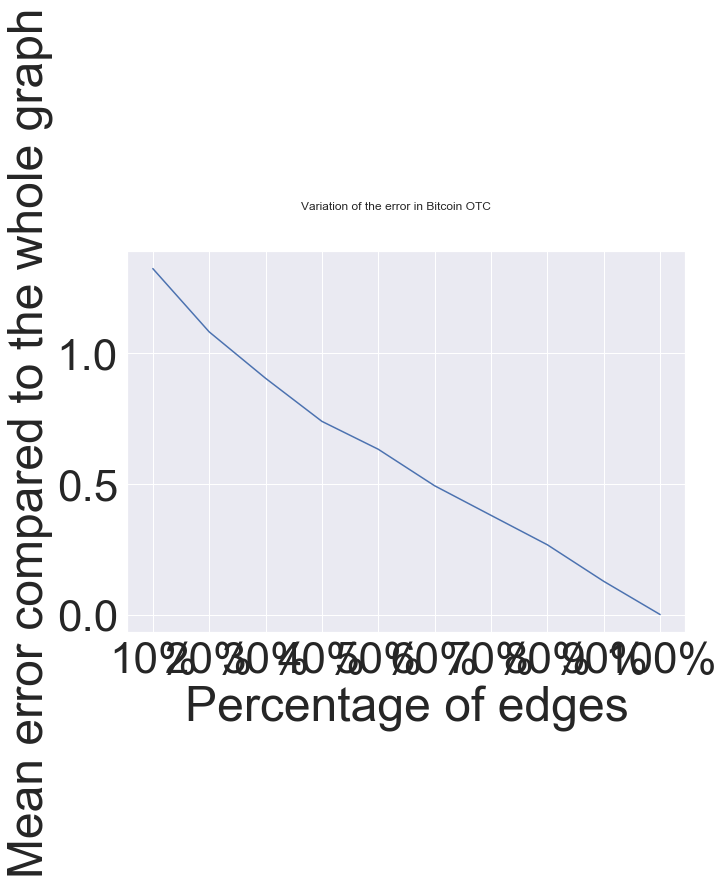

In [162]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,7))

plt.suptitle('Variation of the error in Bitcoin OTC ')
plt.xlabel('Percentage of edges')
plt.ylabel('Mean error compared to the whole graph')
plt.plot(x, y) 

<h0 align=left><font size = 3> 
 Clearily the more we add a new edge we have a smoothly convergenece to the final result which is obtained by considering the whole graph . 
    </font></h0>

## Trust Score Correlations with the other features 

In [163]:
page_rank = nx.pagerank(G, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight=None, dangling=None)

In [164]:
trust= dictionnaire_complet

In [166]:
for key in trust.keys(): 
    trust[key]=trust[key]['trustworthiness']

In [167]:
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)

In [168]:
hub,auth =nx.hits(G, max_iter=100, tol=1e-08, nstart=None, normalized=True)

In [169]:
mean_in = {}
for node in G.nodes():
    mean_in[node]=0

for edge in G.edges(data=True) :  
    mean_in[edge[1]]=mean_in[edge[1]]+(edge[2]['score']/(G.in_degree(edge[1])))

In [170]:
mean_out = {}
for node in G.nodes():
    mean_out[node]=0

for edge in G.edges(data=True) :  
    mean_out[edge[0]]=mean_out[edge[0]]+(edge[2]['score']/(G.out_degree(edge[0])))

In [171]:
st=[]
for key in trust.keys() : 
    st.append([key,out_degree_centrality[key],in_degree_centrality[key],mean_in[key],mean_out[key],hub[key],auth[key],page_rank[key],trust[key]])
    

In [172]:
df=pd.DataFrame(st)

In [175]:
df.columns=['node','out_degree','in_degree','mean_in','mean_out','hub_score','auth_score','page_rank','trustworthiness']

In [176]:
df

,node,out_degree,in_degree,mean_in,mean_out,hub_score,auth_score,page_rank,trustworthiness
0,6,0.006803,0.007483,1.386364,2.425000,1.462917e-03,1.571882e-03,0.000774,1.609091
1,2,0.007653,0.006973,3.000000,3.177778,7.758275e-04,5.890168e-04,0.000977,3.443902
2,5,0.000510,0.000510,2.333333,2.333333,2.087995e-04,1.697030e-04,0.000093,2.800000
3,1,0.036565,0.038435,3.544248,2.013953,4.636831e-03,4.496190e-03,0.005029,3.768142
4,15,0.002551,0.002211,1.538462,1.600000,3.024949e-04,2.946754e-04,0.000323,1.784615
5,4,0.010714,0.009184,3.111111,2.777778,1.507356e-03,1.119703e-03,0.001290,3.266667
6,3,0.000000,0.003571,-0.285714,0.000000,0.000000e+00,5.475613e-04,0.000383,-0.495238
7,13,0.035714,0.032483,1.785340,1.361905,4.512776e-03,3.813520e-03,0.004286,1.771728
8,16,0.000000,0.000170,8.000000,0.000000,0.000000e+00,8.329469e-05,0.000052,0.000000
9,10,0.001361,0.000850,6.000000,7.000000,3.013670e-04,2.481370e-04,0.000134,7.200000


In [177]:
df.drop(['node'], axis = 1,inplace = True)

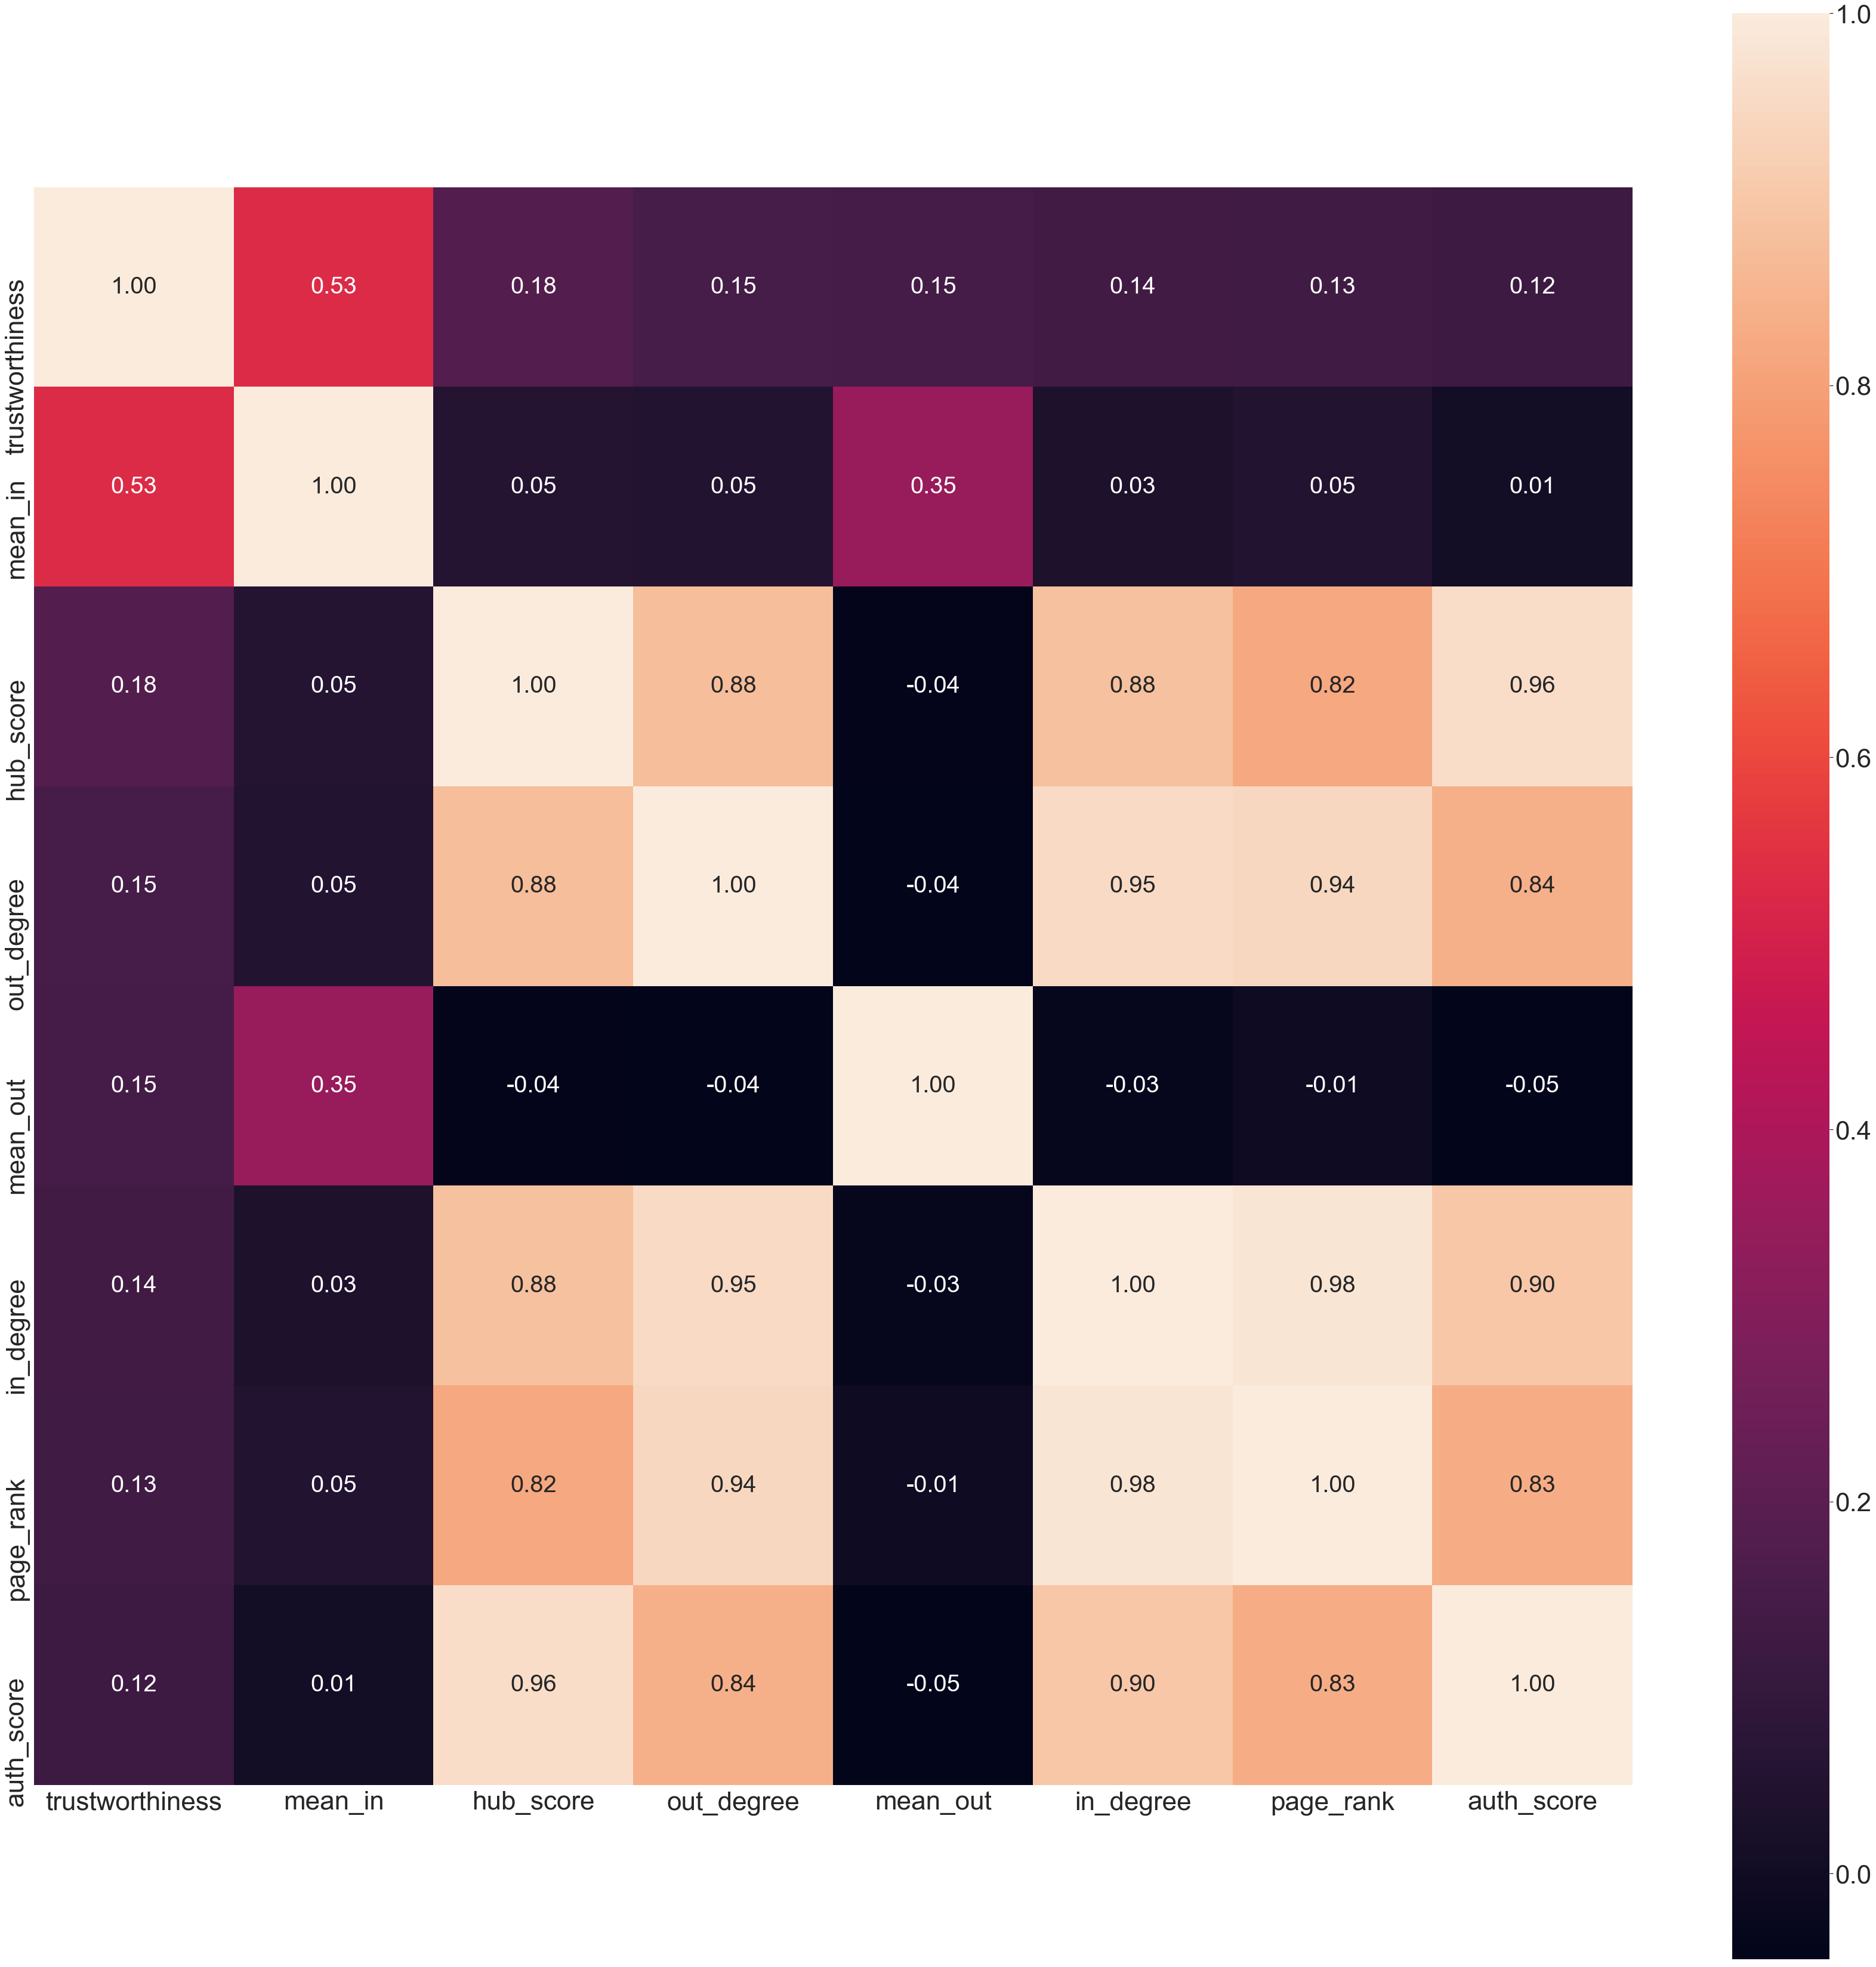

In [179]:
#correlation matrix
corrmat =abs(df.corr())

#saleprice correlation matrix
k = 8 #number of variables for heatmap
cols = corrmat.nlargest(k, 'trustworthiness')['trustworthiness'].index
f, ax = plt.subplots(figsize=(60,60))
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=4)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 40}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Comparing the correlations of scoringRank results with pageRank and the Hits algorithm 

<h0 align=left><font size = 4> 
Considering the results of theses three algorithms with the score given from a node to another. The more correlated the algorithms are the more these algorithms are interesting . 
    </font></h0>

In [51]:
G.edges(data=True)

OutEdgeDataView([(6, 2, {'score': 4}), (6, 5, {'score': 2}), (6, 4, {'score': 2}), (6, 7, {'score': 5}), (6, 114, {'score': 2}), (6, 32, {'score': 1}), (6, 173, {'score': 3}), (6, 258, {'score': 1}), (6, 268, {'score': 3}), (6, 219, {'score': 4}), (6, 198, {'score': 2}), (6, 35, {'score': 4}), (6, 664, {'score': 1}), (6, 937, {'score': 1}), (6, 384, {'score': 6}), (6, 521, {'score': 1}), (6, 280, {'score': 1}), (6, 687, {'score': 1}), (6, 1386, {'score': 3}), (6, 537, {'score': 5}), (6, 1317, {'score': 2}), (6, 1566, {'score': 1}), (6, 2034, {'score': 1}), (6, 2455, {'score': 1}), (6, 1383, {'score': -10}), (6, 1810, {'score': 3}), (6, 2028, {'score': 1}), (6, 1363, {'score': 8}), (6, 10, {'score': 3}), (6, 1, {'score': 8}), (6, 1018, {'score': 1}), (6, 1832, {'score': 1}), (6, 1624, {'score': 3}), (6, 550, {'score': 1}), (6, 1331, {'score': -10}), (6, 2642, {'score': 4}), (6, 856, {'score': 8}), (6, 2188, {'score': 9}), (6, 2187, {'score': 5}), (6, 1752, {'score': 5}), (2, 21, {'score

In [52]:
scoringRank_results = scoringRank (G,alpha=0.8,betta=3,gamma=0.3,num_iter=3)

In [53]:
scoringRank_results;

In [54]:
page_rank = nx.pagerank(G, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight=None, dangling=None)

In [55]:
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)

In [56]:
hub,auth =nx.hits(G, max_iter=100, tol=1e-08, nstart=None, normalized=True)

In [57]:
mean_in = {}
for node in G.nodes():
    mean_in[node]=0

for edge in G.edges(data=True) :  
    mean_in[edge[1]]=mean_in[edge[1]]+(edge[2]['score']/(G.in_degree(edge[1])))

In [58]:
mean_out = {}
for node in G.nodes():
    mean_out[node]=0

for edge in G.edges(data=True) :  
    mean_out[edge[0]]=mean_out[edge[0]]+(edge[2]['score']/(G.out_degree(edge[0])))

In [59]:
st = []
for edge in G.edges(data=True) : 
    l= [(edge[0],edge[1]),out_degree_centrality[edge[0]],out_degree_centrality[edge[1]],in_degree_centrality[edge[0]],in_degree_centrality[edge[1]],page_rank[edge[0]],page_rank[edge[1]],hub[edge[0]],hub[edge[1]],auth[edge[0]],auth[edge[1]],mean_in[edge[0]],mean_in[edge[1]],mean_out[edge[0]],mean_out[edge[1]],scoringRank_results[edge[0]]['trust'],scoringRank_results[edge[1]]['trust'],edge[2]['score']]
    st.append(l)

In [60]:
df=pd.DataFrame(st)

In [61]:
df.columns=['edge','out_degree_1','out_degree_2','in_degree_1','in_degree_2','page_rank_1','page_rank_2','hub_score_1','hub_score_2','auth_score_1','auth_score_2','mean_in_1','mean_in_2','mean_out_1','mean_out_2','trust_score_1','trust_score_2','score_1->2']

In [62]:
df

,edge,out_degree_1,out_degree_2,in_degree_1,in_degree_2,page_rank_1,page_rank_2,hub_score_1,hub_score_2,auth_score_1,auth_score_2,mean_in_1,mean_in_2,mean_out_1,mean_out_2,trust_score_1,trust_score_2,score_1->2
0,"(6, 2)",0.006803,0.007653,0.007483,0.006973,0.000774,0.000977,1.462917e-03,0.000776,1.571882e-03,5.890168e-04,1.386364,3.000000,2.425,3.177778,1.609091,3.443902,4
1,"(6, 5)",0.006803,0.000510,0.007483,0.000510,0.000774,0.000093,1.462917e-03,0.000209,1.571882e-03,1.697030e-04,1.386364,2.333333,2.425,2.333333,1.609091,2.800000,2
2,"(6, 4)",0.006803,0.010714,0.007483,0.009184,0.000774,0.001290,1.462917e-03,0.001507,1.571882e-03,1.119703e-03,1.386364,3.111111,2.425,2.777778,1.609091,3.266667,2
3,"(6, 7)",0.006803,0.039456,0.007483,0.036735,0.000774,0.005912,1.462917e-03,0.003094,1.571882e-03,2.613629e-03,1.386364,2.842593,2.425,2.202586,1.609091,2.753704,5
4,"(6, 114)",0.006803,0.001020,0.007483,0.001531,0.000774,0.000250,1.462917e-03,0.000147,1.571882e-03,1.595511e-04,1.386364,1.222222,2.425,1.166667,1.609091,1.333333,2
5,"(6, 32)",0.006803,0.001020,0.007483,0.001020,0.000774,0.000165,1.462917e-03,0.000362,1.571882e-03,2.905247e-04,1.386364,1.000000,2.425,1.000000,1.609091,1.200000,1
6,"(6, 173)",0.006803,0.000510,0.007483,0.000680,0.000774,0.000107,1.462917e-03,0.000040,1.571882e-03,7.089959e-05,1.386364,1.750000,2.425,1.000000,1.609091,2.100000,3
7,"(6, 258)",0.006803,0.000340,0.007483,0.000340,0.000774,0.000076,1.462917e-03,0.000038,1.571882e-03,2.732744e-05,1.386364,1.500000,2.425,1.000000,1.609091,0.000000,1
8,"(6, 268)",0.006803,0.000850,0.007483,0.000850,0.000774,0.000145,1.462917e-03,0.000072,1.571882e-03,4.057512e-05,1.386364,3.200000,2.425,4.000000,1.609091,3.360000,3
9,"(6, 219)",0.006803,0.003061,0.007483,0.003061,0.000774,0.000380,1.462917e-03,0.000342,1.571882e-03,3.321198e-04,1.386364,1.222222,2.425,2.444444,1.609091,1.444444,4


In [63]:
df.drop(['edge'], axis = 1,inplace = True)

In [64]:
df.columns

Index(['out_degree_1', 'out_degree_2', 'in_degree_1', 'in_degree_2',
       'page_rank_1', 'page_rank_2', 'hub_score_1', 'hub_score_2',
       'auth_score_1', 'auth_score_2', 'mean_in_1', 'mean_in_2', 'mean_out_1',
       'mean_out_2', 'trust_score_1', 'trust_score_2', 'score_1->2'],
      dtype='object')

In [65]:
len(df.columns)

17

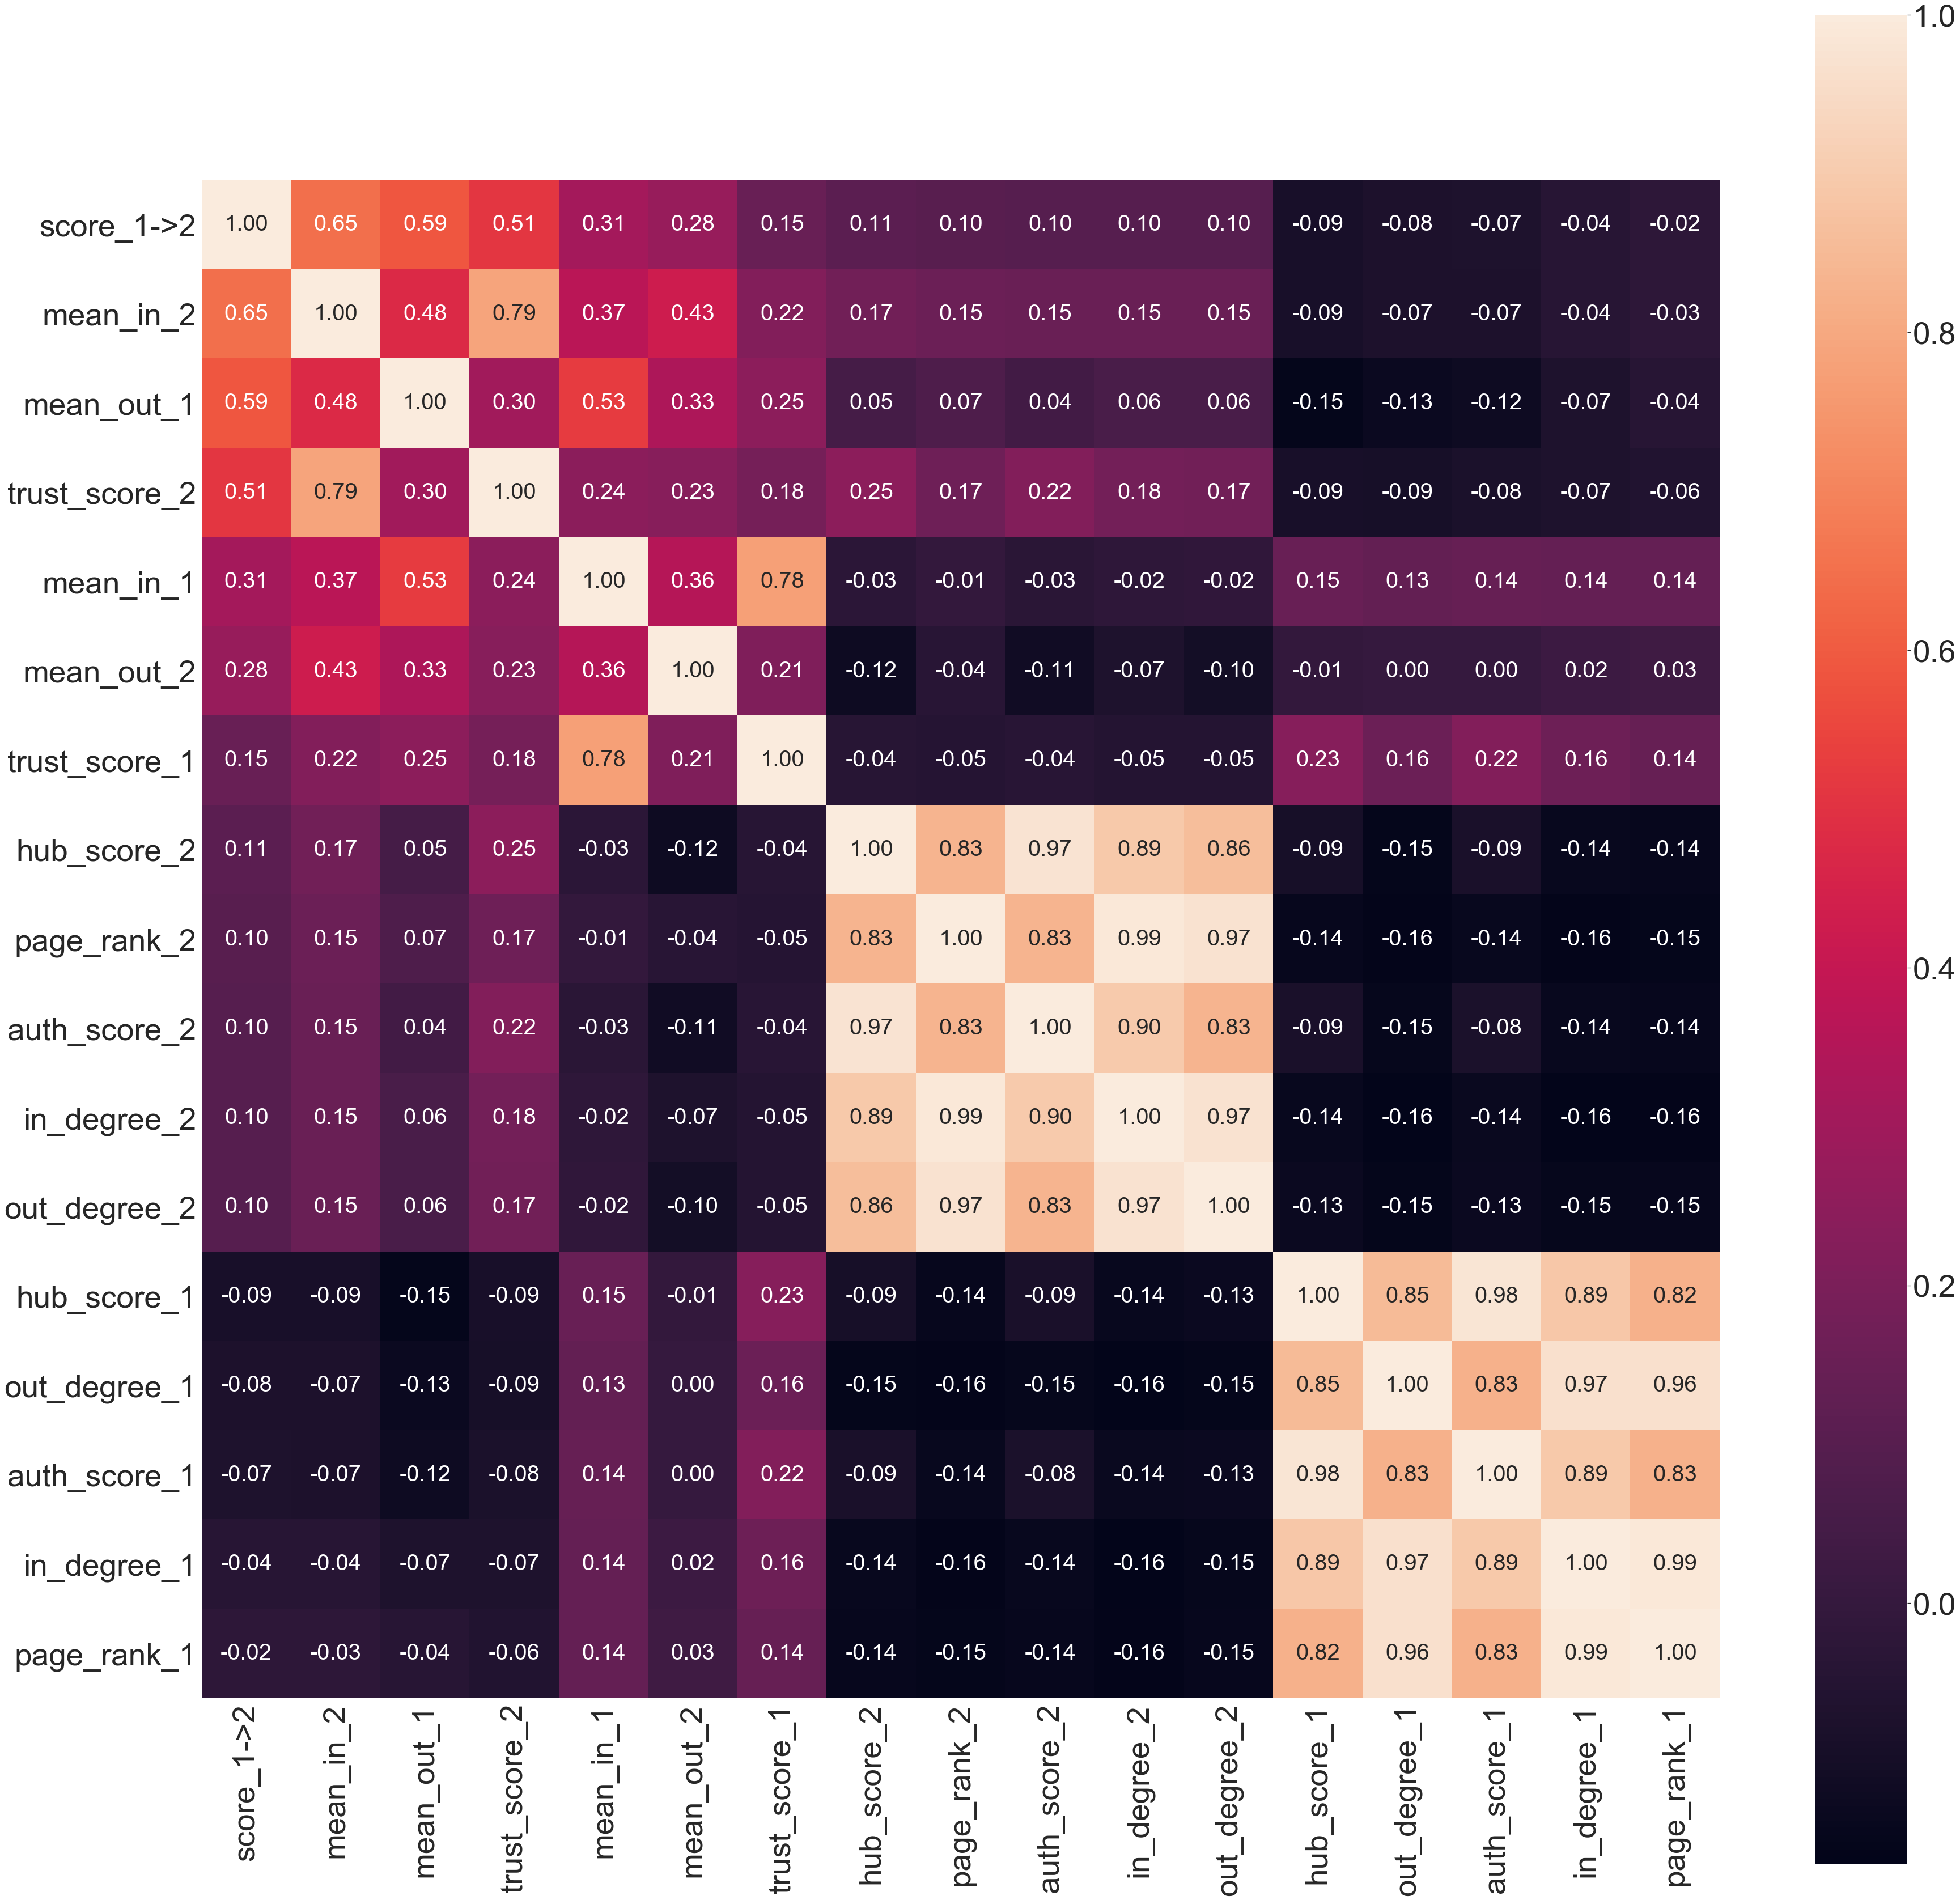

In [66]:
#correlation matrix
corrmat =abs(df.corr())

#saleprice correlation matrix
k = 17 #number of variables for heatmap
cols = corrmat.nlargest(k, 'score_1->2')['score_1->2'].index
f, ax = plt.subplots(figsize=(60,60))
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 40}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [67]:
df.drop(['out_degree_1', 'out_degree_2', 'in_degree_1', 'in_degree_2',], axis = 1,inplace = True)

In [68]:
df.drop(['mean_in_1','mean_in_2','mean_out_1','mean_out_2'],axis=1,inplace=True)

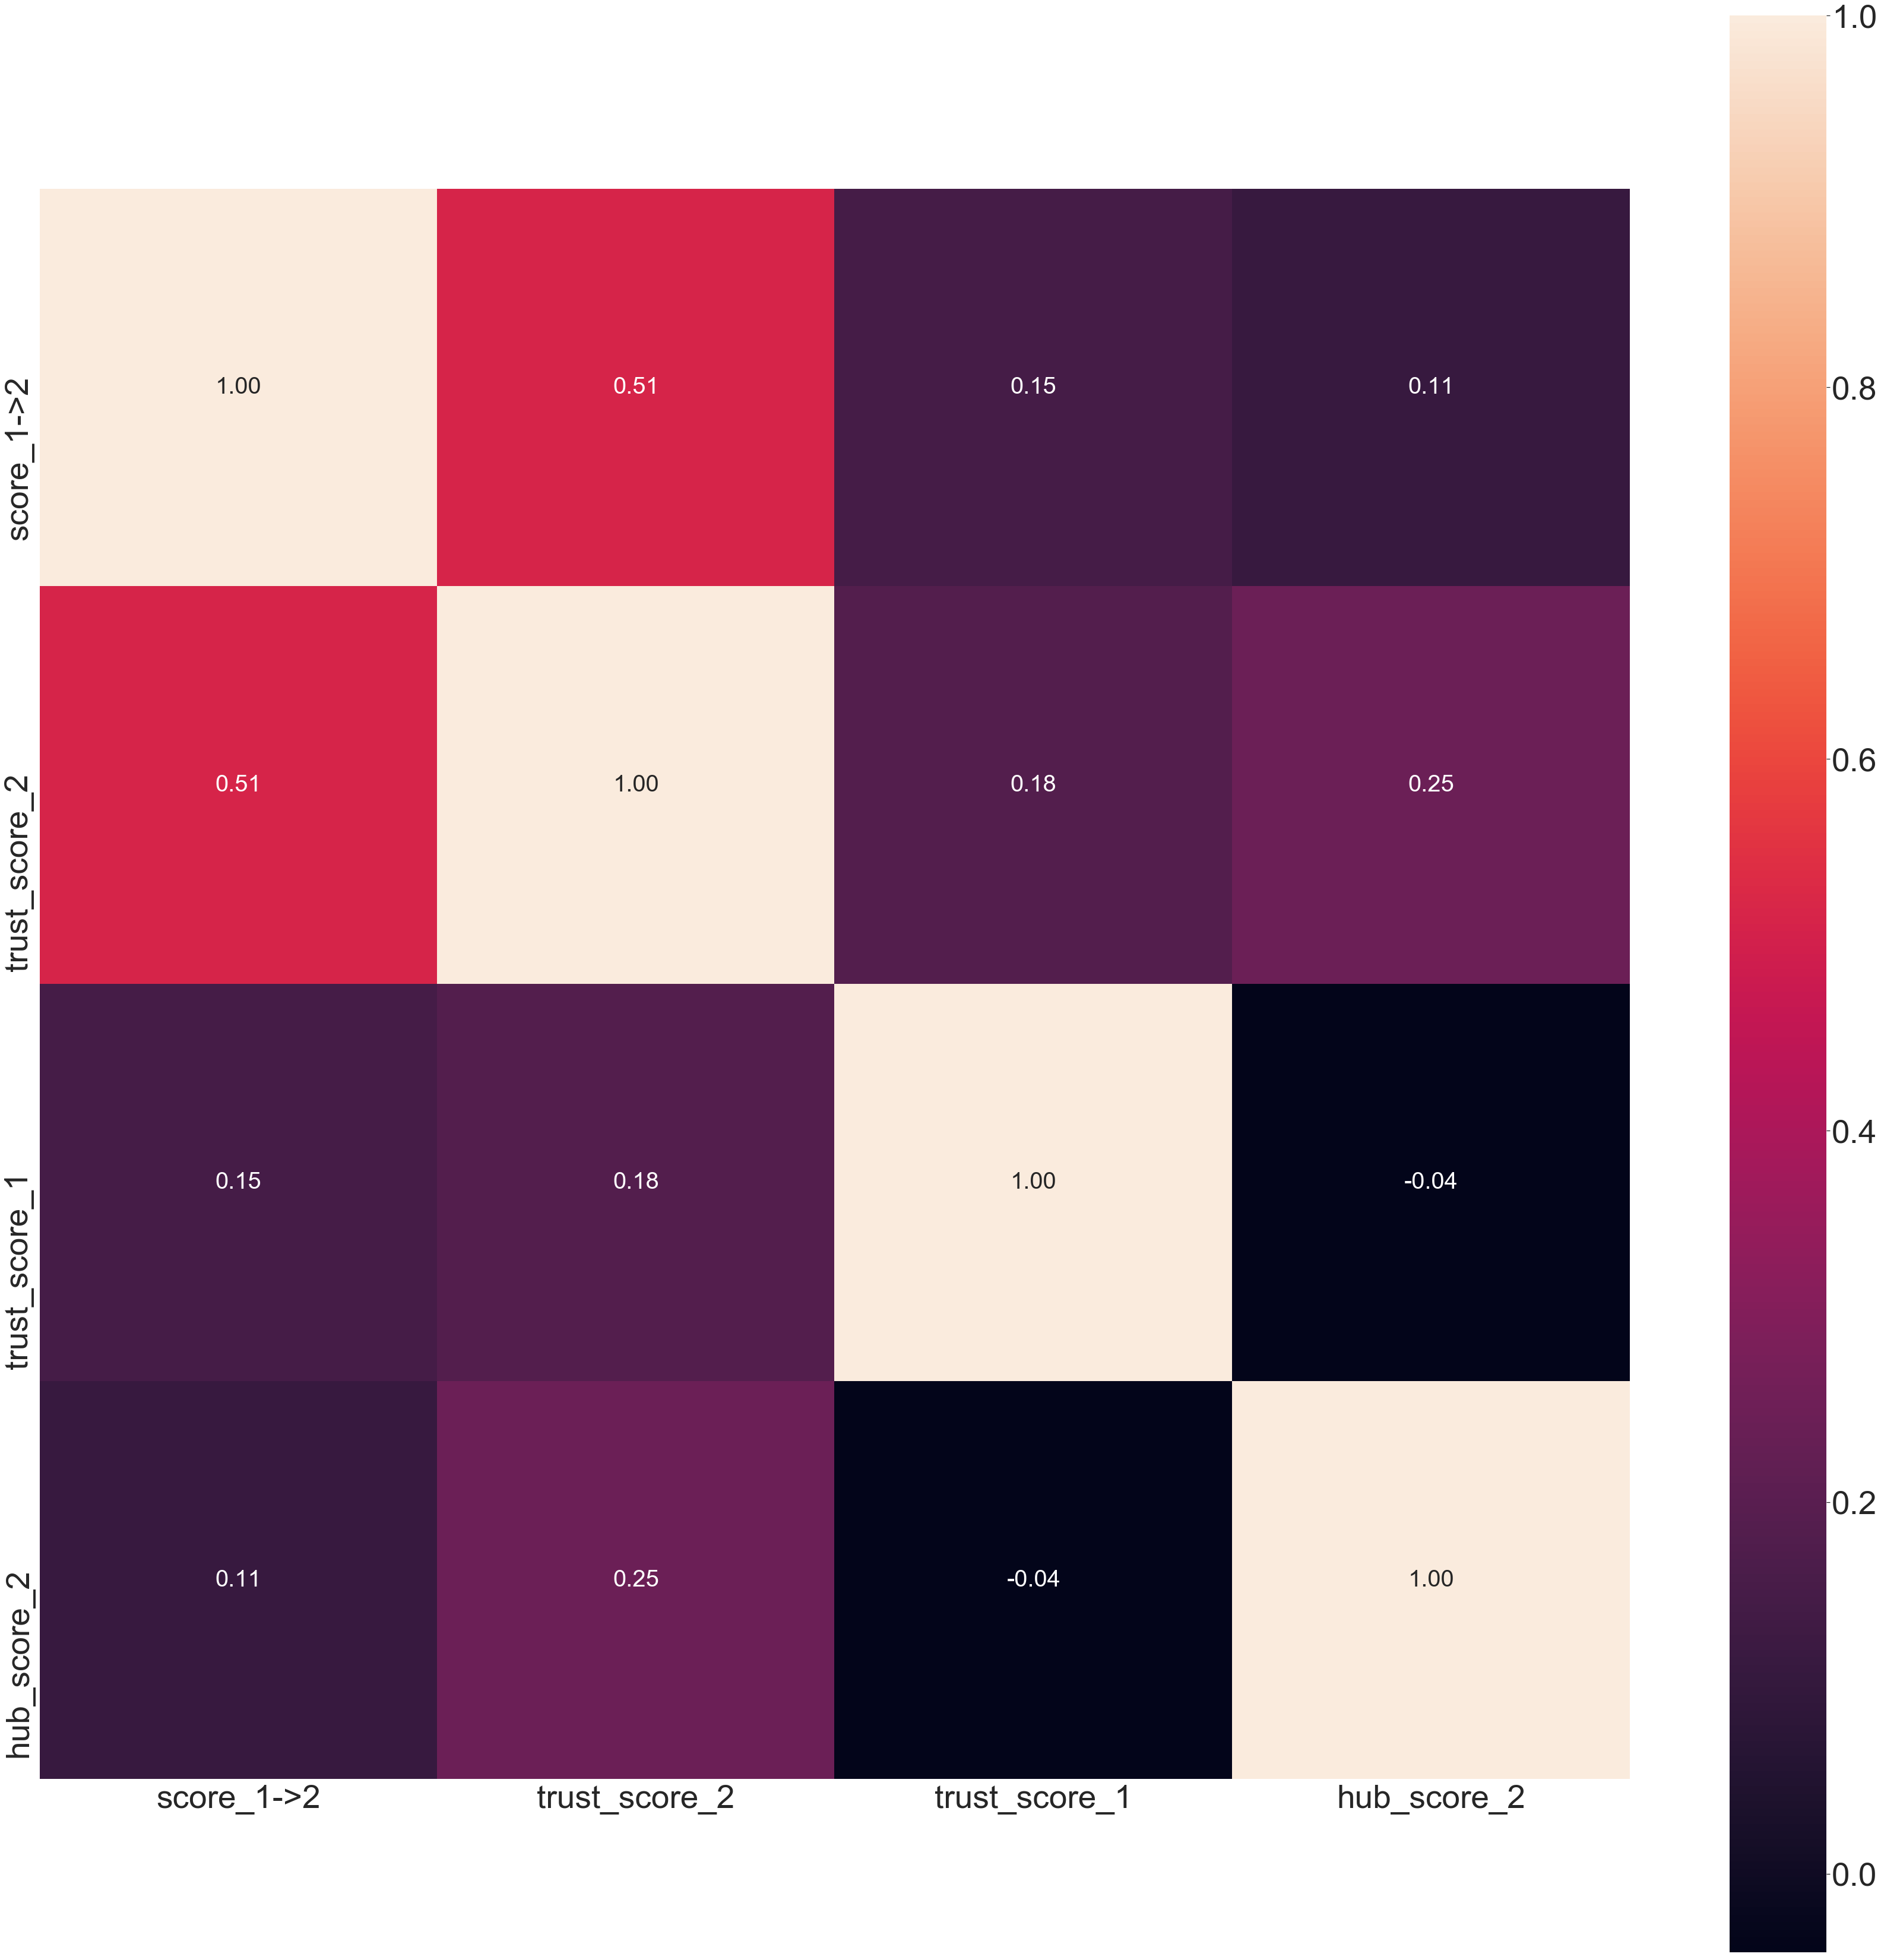

In [69]:
#correlation matrix
corrmat =abs(df.corr())

#saleprice correlation matrix
k = 4 #number of variables for heatmap
cols = corrmat.nlargest(k, 'score_1->2')['score_1->2'].index
f, ax = plt.subplots(figsize=(60,60))
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 40}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()